In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io as sio #to load mat files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<h1> 1. Loading CMU Faces dataset </h1>

In [2]:
print sio.whosmat('../datasets/CMU(30x11x21x1024).mat')
matTF = sio.loadmat('../datasets/CMU(30x11x21x1024).mat')#loading tensor of formatted faces' images
TF = matTF['FullTensor']
print TF.shape
MF = np.reshape(TF,(30*11*21,1024))
print MF.shape

[('FullTensor', (30, 11, 21, 1024), 'uint8')]
(30, 11, 21, 1024)
(6930, 1024)


<h2> Preprocessing incomplete objects </h2>

In [3]:
rt_obinc = 0.4 # rate of objects incomplete
rt_incpob = 0.5 # rate of minimun elements (attributes or variables) incomplete for each object
idx_inc = np.sort(np.random.choice(MF.shape[0], MF.shape[0]*rt_obinc, replace=False))
idx_v = np.ones(MF.shape[0])
idx_v[idx_inc] = 0
idx_s = np.vstack((idx_v,idx_v)).repeat([1,MF.shape[1]-1],0).T
idx_com = np.arange(0,MF.shape[0]-1)
idx_com = np.delete(idx_com, idx_inc)

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [4]:
idx_s2 = np.copy(idx_s) # idx_s2 could have partially incomplete objects
for i in idx_inc:
    idx_s2[i] = np.random.permutation(np.append(np.ones(round(MF.shape[1]*(1-rt_incpob))),np.zeros(round(MF.shape[1]*rt_incpob))))

#plt.pcolor(idx_s2)
#plt.colorbar()

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [5]:
MF_ci = MF * idx_s2
MF_i = MF_ci[idx_inc]#subset with incomplete elements
MF_c = MF_ci[idx_com]#subset with complete elements
#plt.pcolor(MF_ci)
#plt.colorbar()

<h1>2. Kernel Completion Using Convex-NMF </h1>

In [6]:
import kernel as kernel
import pymf
from pymf.cnmf import CNMF 
from kcnmf import KCNMF 
import time

In [7]:
TL_ = np.repeat(np.array(np.arange(1,22), ndmin = 2),11,axis=0)
TL = np.repeat(np.array(TL_,ndmin = 3),30,axis=0)
print TL.shape
ML = np.reshape(TL,(30*11*21,1))
print ML.shape
ML_c = ML[idx_com]
print ML_c.shape

(30, 11, 21)
(6930, 1)
(4157, 1)


In [8]:
TP_ = np.repeat(np.array([175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170], ndmin = 2),21,axis=0)
TP = np.repeat(np.array(TP_.T,ndmin = 3),30,axis=0)
print TP.shape
MP = np.reshape(TP,(30*11*21,1))
print MP.shape
MP_c = MP[idx_com]
print MP_c.shape

(30, 11, 21)
(6930, 1)
(4157, 1)


In [9]:
#30x11x21x1024
eq = 1
diff = 0.3
poses = [175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170]
illuminations = np.arange(1,22)
TS = np.zeros((30,11,21))
for i in range(30):
    for j in range(len(poses)):
        for k in range(len(illuminations)):
            TS[i,j,k] = i
            
MS = np.reshape(TS,(30*11*21,1))


In [10]:
#Kernel for subject (approach 2)
Ks = np.zeros((len(idx_com),len(idx_com)))
for i in range(len(idx_com)):
    for j in range(len(idx_com)):
        if MS[i]==MS[j]:
            Ks[i,j] = eq
        else:
            Ks[i,j] = diff
print Ks.shape        
#plt.pcolor(Ks[350:,350:])
#plt.colorbar()

(4157, 4157)


In [11]:
#Kernel for subject (approach 1)
Ks1 = np.zeros((MF.shape[0],MF.shape[0]))
for i in range(MF.shape[0]):
    for j in range(MF.shape[0]):
        if MS[i]==MS[j]:
            Ks1[i,j] = eq
        else:
            Ks1[i,j] = diff

In [11]:
#kernels parameters
sigmas = 10.5
sigmal = 1500.0 #100.0#1.6#
sigmap = 350.5#1000.0#4.5#
sigmai = 500.0#10000.0#1000#

In [13]:
#Kernel for subject rbf (2)
Ks = kernel._get_kernel(MS[idx_com], MS[idx_com],'rbf', gamma=(2*sigma)**-2)
Ks1 = kernel._get_kernel(MS, MS,'rbf', gamma=(2*sigmas)**-2)#(apprach 1)

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


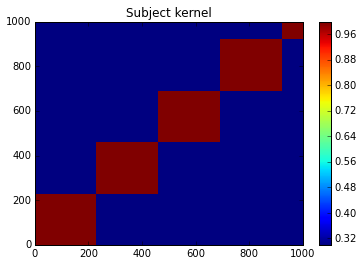

In [12]:
plt.pcolor(Ks[:1000,:1000])
plt.colorbar()
plt.title('Subject kernel')

In [15]:
#Kernel for illumination
Kl = kernel._get_kernel(ML_c, ML_c,'rbf', gamma=(2*sigmal)**-2)
Kl1 = kernel._get_kernel(ML, ML,'rbf', gamma=(2*sigmal)**-2)#(approach 1)

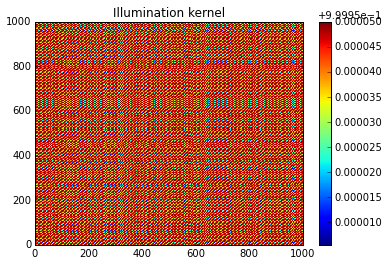

In [16]:
plt.pcolor(Kl[:1000,:1000])
plt.colorbar()
plt.title('Illumination kernel')

In [17]:
#Kernel for pose
Kp = kernel._get_kernel(MP_c, MP_c,'rbf', gamma=(2*sigmap)**-2)
Kp1 = kernel._get_kernel(MP, MP,'rbf', gamma=(2*sigmap)**-2)#(approach 1)

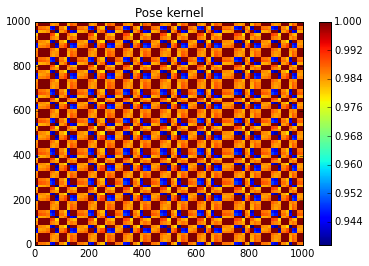

In [18]:
plt.pcolor(Kp[:1000,:1000])
plt.colorbar()
plt.title('Pose kernel')

In [19]:
#Kernel for image
Ki = kernel._get_kernel(MF_c, MF_c,'rbf', gamma=(2*sigmai)**-2)
Ki1 = kernel._get_kernel(MF_ci, MF_ci,'rbf', gamma=(2*sigmai)**-2)#(approach 1)
#print Ki.shape

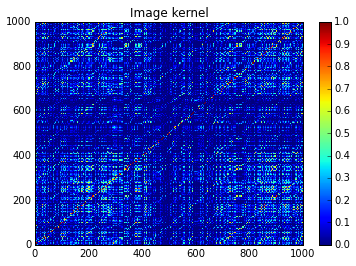

In [20]:
plt.pcolor(Ki[:1000,:1000])
plt.colorbar()
plt.title('Image kernel')

In [22]:
#Kt = ks x Kp x kl x ki
#Kt = np.dot(np.dot(np.dot(Ks,Kp),Kl),Ki)
Kt = Ks*Kp*Kl*Ki
print Kt.shape
#Kt1 = Ks1*Kp1*Kl1*Ki1
#print Kt1.shape

(4157, 4157)


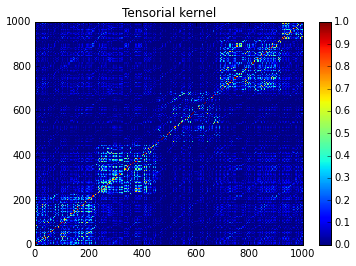

In [23]:
plt.pcolor(Kt[:1000,:1000])
plt.colorbar()
plt.title('Tensorial kernel')

In [24]:
#Factorize (approach 2)
tic = time.clock()#get start time
cnmf_kt_c = KCNMF(Kt, num_bases=30)
cnmf_kt_c.factorize(niter=10)
print 'RSE:', np.linalg.norm(Kt - np.dot(cnmf_kt_c.W,cnmf_kt_c.H))/np.linalg.norm(Kt)
toc = time.clock()#get final time
print 'Time: ', toc - tic

RSE: 0.561575688539
Time:  66.685371


In [57]:
#Factorize (approach 1)
tic = time.clock()#get start time
cnmf_kt = KCNMF(Kt1, num_bases=30)
cnmf_kt.factorize(niter=10)
print np.linalg.norm(Kt1 - np.dot(cnmf_kt.W,cnmf_kt.H))/np.linalg.norm(Kt1)
toc = time.clock()#get final time
print 'Time: ', toc - tic

0.115862217837
Time:  614.973416


<h2>3.2 Completion: Finding $h_j$ to incomplete objects</h2>


Given an incomplete object $x_j$
$$\min_{h_j}||\phi(x_j)-\phi(X)Gh_j||^2$$
$$=\min_{h_j}h_j^TK(X,X)Gh_j - 2K(X,x_j)Gh_j$$
Using pseudo-inverse
$$h_j=(G^TK(X,X)G+\lambda I)^-1G^TK(X,x_j)$$

Compute $h_j$ for each incomplete object $x_j$:

In [26]:
lamb = 1e-10
bases = 30#19

mask = 1
normalize = 2

#H1_i = np.zeros((bases, len(idx_inc)))
#H2_i = np.zeros((bases, len(idx_inc)))
#H3_i = np.zeros((bases, len(idx_inc)))
H4_i = np.zeros((bases, len(idx_inc)))
#H5_i = np.zeros((bases, len(idx_inc)))
k=0
#auxpi5 = np.linalg.inv(np.dot(ok.W.T, ok.W)+ lamb*np.identity(bases))
auxpi4 = np.linalg.inv(np.dot(cnmf_kt_c.W.T, cnmf_kt_c.G)+ lamb*np.identity(bases))
#auxpi3 = np.dot(cnmf_kt_c.W.T, np.linalg.inv( np.dot(cnmf_kt_c.W,cnmf_kt_c.W.T)+ lamb*np.identity(cnmf_kt_c.W.shape[0]) ) )
#auxpi2 = np.dot( np.dot(cnmf_kt_c.W.T, cnmf_kt_c.W)+ lamb*np.identity(bases),cnmf_kt_c.W.T )
#auxpi1 = np.linalg.pinv(cnmf_kt_c.W)
for j in idx_inc:
    #Ksx = kernel._get_kernel(MS[j], MS[j],'rbf', gamma=(2*sigmas)**-2)
    #Kernel for illumination
    Klx = kernel._get_kernel(ML_c, ML[j],'rbf', gamma=(2*sigmal)**-2)
    #Kernel for pose
    Kpx = kernel._get_kernel(MP_c, MP[j],'rbf', gamma=(2*sigmap)**-2)
    #Kernel for image
    #Kix = kernel._get_kernel(MF_c, MF_ci[j],'rbf', gamma=(2*sigmap)**-2)
    if mask == 1:
        Kix = kernel._get_kernel(idx_s2[j]*MF_c, MF[j],'rbf', gamma=(2*sigmap)**-2)#complete image
    else:
        Kix = kernel._get_kernel(MF_c, MF[j],'rbf', gamma=(2*sigmap)**-2)#complete image
    #Kix = kernel._get_kernel(MF_c, MF[j],'linear')
    #Kernle for subject
    #...
    Ksx = np.zeros((len(idx_com),1))
    for i in range(len(idx_com)):
        if MS[i]==MS[j]: Ksx[i] = eq
        else: Ksx[i] = diff
    #print Ksx.shape  
    Ktx = Ksx*Kpx*Klx*Kix
    #H5_i[:,k] = np.squeeze(np.dot(auxpi5, np.dot(ok.W.T, Ktx) ))
    H4_i[:,k] = np.squeeze(np.dot(auxpi4, np.dot(cnmf_kt_c.G.T, Ktx) ))
    #H3_i[:,k] = np.squeeze(np.dot(auxpi3,Ktx))
    #H2_i[:,k] = np.squeeze(np.dot(auxpi2,Ktx))
    #H1_i[:,k] = np.squeeze(np.dot(auxpi1,Ktx))
    if normalize==1:
        H4_i[:,k] = (H4_i[:,k]+abs(min(H4_i[:,k]))) / sum(H4_i[:,k]+abs(min(H4_i[:,k])))
    if normalize ==2:
        H4_i[:,k] = abs(H4_i[:,k])
    k+=1

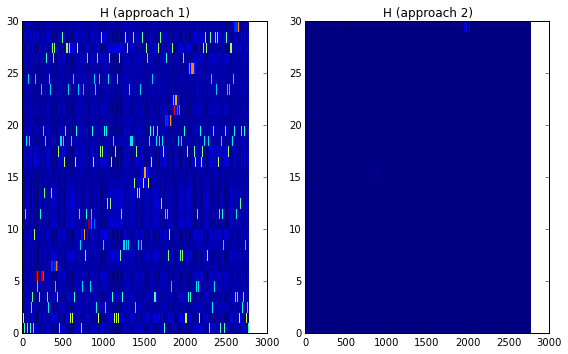

In [83]:
#plt.pcolor(H4_i)
f, axarr = plt.subplots(1, 2)
axarr[0].pcolor(cnmf_kt.H[:,idx_inc])
axarr[0].set_title('H (approach 1)')
axarr[1].pcolor(H4_i)
axarr[1].set_title('H (approach 2)')
f.set_size_inches(8,5)
f.tight_layout()

<h2>2.4 Solve the pre-image problem</h2>

Given an incomplete object $x_j$
$$\phi(x_j) \approx \phi(X)Gh_j$$
The preimage problem consists of find $x*$ such that $\phi(x*) \approx \phi(x_j)$ or $$\phi(x*) \approx \phi(X)Gh_j$$

In [27]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 30#19
MFpreim_ci = np.copy(MF_ci)
tic = time.clock()#get start time
for j in range(len(idx_inc)):
    print 'Compute pre-image for object',idx_inc[j]
    alpha = np.dot(cnmf_kt_c.G, H4_i[:,j]) #np.mean(cnmf_kg.H,0)    
    #alpha = np.dot(ok.W, H5_i[:,j])    
    try:
        MFpreim_ci[idx_inc[j]], trainErrorskl = kernel.preimage(MF_c, alpha, 'rbf', gamma=(2*sigmal)**-2+(2*sigmap)**-2+(2*sigmai)**-2)
    except:
        print 'Problems computing preimage', j
        continue
    
toc = time.clock()#get final time
print 'Time: ',toc - tic

Compute pre-image for object 1
Compute pre-image for object 2
Compute pre-image for object 7
Compute pre-image for object 9
Compute pre-image for object 12
Compute pre-image for object 17
Compute pre-image for object 18
Compute pre-image for object 19
Compute pre-image for object 22
Compute pre-image for object 24
Compute pre-image for object 29
Compute pre-image for object 33
Compute pre-image for object 39
Compute pre-image for object 40
Compute pre-image for object 46
Compute pre-image for object 48
Compute pre-image for object 57
Compute pre-image for object 59
Compute pre-image for object 63
Compute pre-image for object 65
Compute pre-image for object 67
Compute pre-image for object 68
Compute pre-image for object 73
Compute pre-image for object 74
Compute pre-image for object 80
Compute pre-image for object 82
Compute pre-image for object 83
Compute pre-image for object 84
Compute pre-image for object 85
Compute pre-image for object 86
Compute pre-image for object 88
Compute pre-

Cualitative results

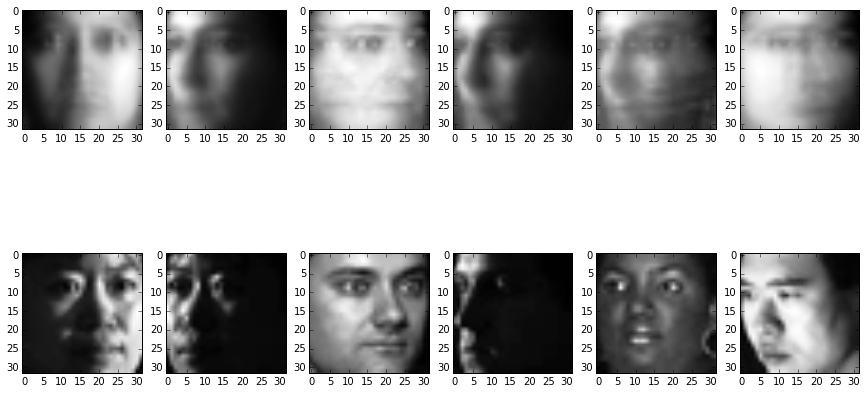

In [28]:
f, axarr = plt.subplots(2, 6)
axarr[0,0].imshow( np.reshape(MFpreim_ci[idx_inc[8],:],(32,32)).T, cmap='Greys_r' )
axarr[0,1].imshow( np.reshape(MFpreim_ci[idx_inc[36],:],(32,32)).T, cmap='Greys_r' )
axarr[0,2].imshow( np.reshape(MFpreim_ci[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[0,3].imshow( np.reshape(MFpreim_ci[idx_inc[600],:],(32,32)).T, cmap='Greys_r' )
axarr[0,4].imshow( np.reshape(MFpreim_ci[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[0,5].imshow( np.reshape(MFpreim_ci[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,0].imshow( np.reshape(MF[idx_inc[8],:],(32,32)).T, cmap='Greys_r' )
axarr[1,1].imshow( np.reshape(MF[idx_inc[36],:],(32,32)).T, cmap='Greys_r' )
axarr[1,2].imshow( np.reshape(MF[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,3].imshow( np.reshape(MF[idx_inc[600],:],(32,32)).T, cmap='Greys_r' )
axarr[1,4].imshow( np.reshape(MF[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[1,5].imshow( np.reshape(MF[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
f.set_size_inches(15,8)
#f.savefig('/home/rajaquep/outcomes/foo.png')


In [29]:
print 'RSE completion', np.linalg.norm(MF[idx_inc] - MFpreim_ci[idx_inc])/np.linalg.norm(MF[idx_inc])
print 'RSE whole original', np.linalg.norm(MF - MFpreim_ci)/np.linalg.norm(MF)
print 'RSE whole input', np.linalg.norm(MF_ci - MFpreim_ci)/np.linalg.norm(MF_ci)

RSE completion 0.551584825287
RSE whole original 0.349567546028
RSE whole input 0.448144763684


Solve preimage (approach 1)

In [65]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 30#19
MFpreim_ci1 = np.copy(MF_ci)
tic = time.clock()#get start time
for j in range(len(idx_inc)):
    print 'Compute pre-image for object',idx_inc[j]
    alpha = np.dot(cnmf_kt.G, cnmf_kt.H[:,j]) #np.mean(cnmf_kg.H,0)    
    #alpha = np.dot(ok.W, H5_i[:,j])    
    try:
        MFpreim_ci1[idx_inc[j]], trainErrorskl = kernel.preimage(MF_ci, alpha, 'rbf', gamma=(2*sigmas)**-2+(2*sigmal)**-2+(2*sigmap)**-2+(2*sigmai)**-2)
    except:
        print 'Problems computing preimage', j
        continue
    
toc = time.clock()#get final time
print 'Time: ',toc - tic

Compute pre-image for object 1
Compute pre-image for object 4
Compute pre-image for object 7
Compute pre-image for object 8
Compute pre-image for object 15
Compute pre-image for object 16
Compute pre-image for object 23
Compute pre-image for object 25
Compute pre-image for object 27
Compute pre-image for object 35
Compute pre-image for object 37
Compute pre-image for object 40
Compute pre-image for object 41
Compute pre-image for object 44
Compute pre-image for object 45
Compute pre-image for object 47
Compute pre-image for object 56
Compute pre-image for object 62
Compute pre-image for object 63
Compute pre-image for object 64
Compute pre-image for object 68
Compute pre-image for object 72
Compute pre-image for object 74
Compute pre-image for object 75
Compute pre-image for object 77
Compute pre-image for object 78
Compute pre-image for object 81
Compute pre-image for object 83
Compute pre-image for object 84
Compute pre-image for object 88
Compute pre-image for object 91
Compute pre-

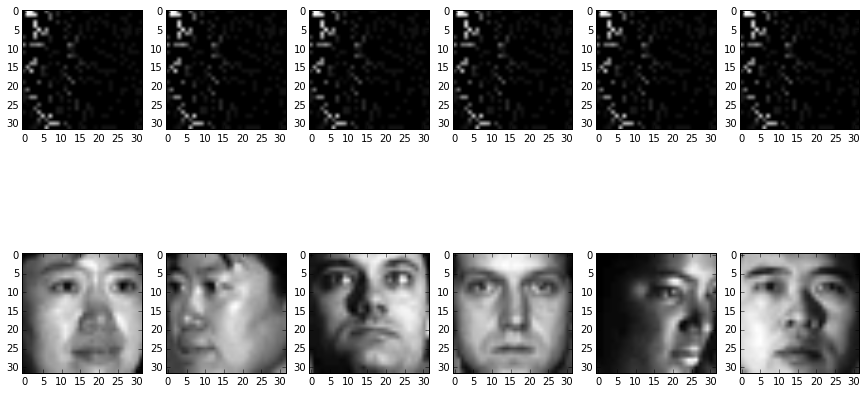

In [66]:
f, axarr = plt.subplots(2, 6)
axarr[0,0].imshow( np.reshape(MFpreim_ci1[idx_inc[8],:],(32,32)).T, cmap='Greys_r' )
axarr[0,1].imshow( np.reshape(MFpreim_ci1[idx_inc[36],:],(32,32)).T, cmap='Greys_r' )
axarr[0,2].imshow( np.reshape(MFpreim_ci1[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[0,3].imshow( np.reshape(MFpreim_ci1[idx_inc[600],:],(32,32)).T, cmap='Greys_r' )
axarr[0,4].imshow( np.reshape(MFpreim_ci1[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[0,5].imshow( np.reshape(MFpreim_ci1[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,0].imshow( np.reshape(MF[idx_inc[8],:],(32,32)).T, cmap='Greys_r' )
axarr[1,1].imshow( np.reshape(MF[idx_inc[36],:],(32,32)).T, cmap='Greys_r' )
axarr[1,2].imshow( np.reshape(MF[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,3].imshow( np.reshape(MF[idx_inc[600],:],(32,32)).T, cmap='Greys_r' )
axarr[1,4].imshow( np.reshape(MF[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[1,5].imshow( np.reshape(MF[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
f.set_size_inches(15,8)
#f.savefig('/home/rajaquep/outcomes/foo.png')


In [67]:
print 'RSE completion', np.linalg.norm(MF[idx_inc] - MFpreim_ci1[idx_inc])/np.linalg.norm(MF[idx_inc])
print 'RSE whole original', np.linalg.norm(MF - MFpreim_ci1)/np.linalg.norm(MF)
print 'RSE whole input', np.linalg.norm(MF_ci - MFpreim_ci1)/np.linalg.norm(MF_ci)

RSE completion 0.982397639005
RSE whole original 0.623621816862
RSE whole input 0.377660300363


In [ ]:
import test_kcnmf

iterations = 5
vrates = [.1, .40, .50, .60, .70, .80, .90, .92, .94, .96, .98]
vsigmal = [2000]#[1500, 2000, 3000]
vsigmai = [500]#[500, 1000]
vnormalize = [2]#[0, 2, 3]
countexp = 1
test_kcnmf.test_cmu3(MF, iterations, vrates, vsigmal, vsigmai, vnormalize, countexp)

In [4]:
#rse STDC
rse_stdc = [.1282, .1878, .2469, .2652, .3087, .2177, .4852, .6168, .7513, .8587, .9324]

In [46]:
#Read Input approach 1 to compare
lines = np.loadtxt("/home/rajaquep/outcomes/cmu_faces_22012017.csv", comments="//", delimiter=",", skiprows=197, usecols=(1,7,8,9), unpack=False)
print lines.shape
linesn2 = lines[range(0,55),:]
linesn3 = lines[range(55,110),:]

(110, 4)


In [51]:
vrates = [.1, .40, .50, .60, .70, .80, .90, .92, .94, .96, .98]
rsev_n2 = []
rsev2_n2 = []
rsev_n3 = []
rsev2_n3 = []
for rt in vrates:
    rsev_n2.append(min(linesn2[linesn2[:,0]==rt,2]))
    rsev2_n2.append(min(linesn2[linesn2[:,0]==rt,3]))
    rsev_n3.append(min(linesn3[linesn3[:,0]==rt,2]))
    rsev2_n3.append(min(linesn3[linesn3[:,0]==rt,3]))


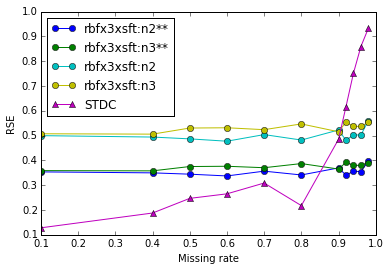

In [57]:
#rsev2_n3 = rsev
plt.plot(vrates,rsev2_n2,'-ob',label='rbfx3xsft:n2**')
plt.plot(vrates,rsev2_n3,'-og',label='rbfx3xsft:n3**')
plt.plot(vrates,rsev_n2,'-oc',label='rbfx3xsft:n2')
plt.plot(vrates,rsev_n3,'-oy',label='rbfx3xsft:n3')
plt.plot(vrates,rse_stdc,'-^m',label='STDC')
plt.legend(loc=2)
plt.ylabel('RSE')
plt.xlabel('Missing rate')

<h2>Lazy Model for image reconstruction</h2>

In [58]:
def avg_pixel(imagev, mask_inc):
    pix_com = range(0,1024)*mask_inc
    pix_inc = range(0,1024)
    pix_inc = np.delete(pix_inc, pix_com).astype(int)
    imagev[pix_inc] = np.tile(sum(imagev)/sum(mask_inc), len(imagev[pix_inc]))
    return imagev

In [60]:
import test_kcnmf

vrates = [.1, .40, .50, .60, .70, .80, .90, .92, .94, .96, .98]
rse_v = []
rse_v2 = []
for rt in vrates:
    MF_ci, idx_inc, idx_com, idx_s2 = test_kcnmf.incomplete_data(MF, rt,0.5)
    MF_rec = MF_ci
    for ic in idx_inc:
        MF_rec[ic] = avg_pixel(MF[ic], idx_s2[ic])
    rse_v.append(np.linalg.norm(MF[idx_inc] - MF_rec[idx_inc])/np.linalg.norm(MF[idx_inc]))
    inv_idx2 = idx_s2+1
    inv_idx2[inv_idx2==2] = 0
    rse_v2.append(np.linalg.norm(MF[idx_inc] - ((MF_rec[idx_inc]*inv_idx2[idx_inc])+MF_ci[idx_inc]))/np.linalg.norm(MF[idx_inc]))

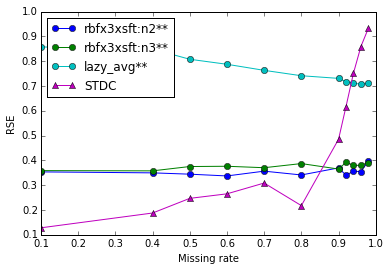

In [62]:
#rsev2_n3 = rsev
plt.plot(vrates,rsev2_n2,'-ob',label='rbfx3xsft:n2**')
plt.plot(vrates,rsev2_n3,'-og',label='rbfx3xsft:n3**')
plt.plot(vrates,rse_v2,'-oc',label='lazy_avg**')
plt.plot(vrates,rse_stdc,'-^m',label='STDC')
plt.legend(loc=2)
plt.ylabel('RSE')
plt.xlabel('Missing rate')

NameError: name 'np' is not defined